In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino
## Session 05 - Decision Trees

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import graphviz

import matplotlib.image as mpimg

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

## Decision Trees
Decision trees at their root are extremely intuitive.  They encode a series of binary choices in a process that parallels how a person might classify things themselves, but using an information criterion to decide which question is most fruitful at each step.  Its like playing 20-questions game.

For example, if you wanted to create a guide to identifying an animal found in nature, you might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

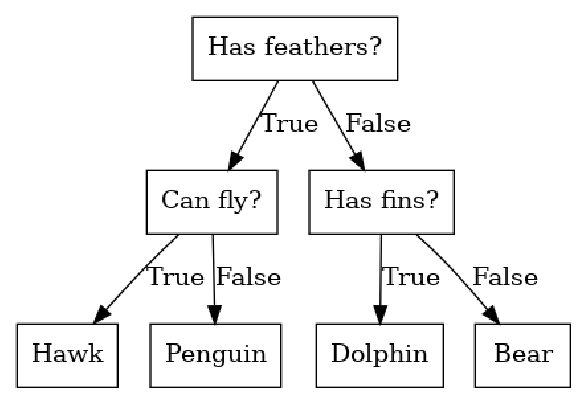

In [5]:
#Instantiate the Graph
decision_tree = graphviz.Digraph(node_attr={'shape': 'box'},
                                 edge_attr={'labeldistance': "10.5"},
                                 format="png")

###---------------
### add some nodes
###---------------
decision_tree.node("0", "Has feathers?")

decision_tree.node("1", "Can fly?")

decision_tree.node("2", "Has fins?")

decision_tree.node("3", "Hawk")

decision_tree.node("4", "Penguin")

decision_tree.node("5", "Dolphin")

decision_tree.node("6", "Bear")

###---------------
### add some edges
###---------------
decision_tree.edge("0", "1", label="True")

decision_tree.edge("0", "2", label="False")

decision_tree.edge("1", "3", label="True")

decision_tree.edge("1", "4", label="False")

decision_tree.edge("2", "5", label="True")

decision_tree.edge("2", "6", label="False")

decision_tree.render("../../images/decision_tree")

fig, ax = plt.subplots()

ax.imshow(mpimg.imread("../../images/decision_tree.png"))

ax.set_axis_off()

plt.show()

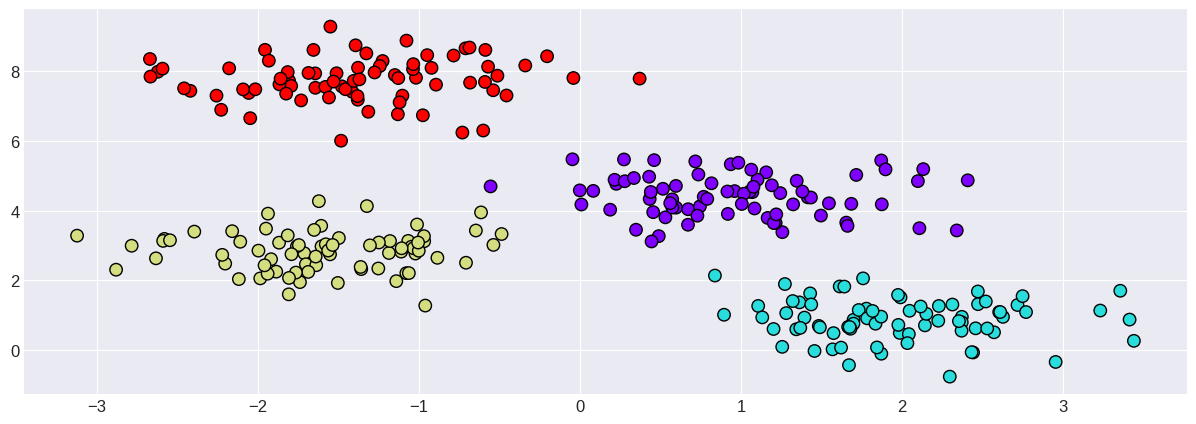

In [6]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, edgecolors='black')

plt.show()

Decision Trees have a number of tunable parameters. 

class sklearn.tree.DecisionTreeClassifier(**criterion**='gini', splitter='best', **max_depth**=None, **min_samples_split**=2, **min_samples_leaf**=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)

Parameters of interest are marked in bold.

## Measure of Impurity    :

|#|Description|Gini Index|Entropy|
|:-:|:--|:--|:--|
|1.|Definition| The Gini index measures the impurity of a set of data points. It is defined as the probability of misclassifying a randomly chosen element if it were randomly classified according to the distribution of labels in the data set. The Gini index ranges from 0 to 0.5, where 0 indicates perfect purity (all elements belong to the same class), and 0.5 indicates maximum impurity (an equal distribution of all classes).|Entropy, in the context of decision trees and information theory, measures the amount of disorder or uncertainty in a set of data points. It quantifies the information content or randomness within a dataset. Entropy ranges from 0 to 1, where 0 indicates perfect purity (all elements belong to the same class), and 1 indicates maximum impurity (an equal distribution of all classes).|
|2.|Calculation|The Gini index is calculated using the formula: Gini(D) = 1 - $\sum(p_i^2)$, where $p_i$ represents the proportion of data points in class i in the dataset D.|The entropy is calculated using the formula: Entropy(D) = $-\sum(p_i * log_2(p_i))$, where $p_i$ represents the proportion of data points in class i in the dataset D. The logarithm base 2 is commonly used in machine learning.
|
|3.|Interpretation|A lower Gini index indicates better purity or less impurity in the data. In decision tree algorithms, a split with a lower Gini index is preferred as it results in more homogeneous subsets.| A lower entropy value indicates better purity or less disorder in the data. In decision tree algorithms, a split with lower entropy is preferred as it results in more homogeneous subsets.
|4.|Decision Tree Splitting| Decision tree algorithms often use the Gini index to measure the impurity reduction when making a split. The split that results in the lowest Gini index (highest impurity reduction) is chosen.|Decision tree algorithms can also use entropy to measure the information gain when making a split. The split that results in the highest information gain (lowest entropy) is chosen.|

In [7]:
clf = DecisionTreeClassifier(max_depth=10)

clf.fit(X,y)

DecisionTreeClassifier(max_depth=10)

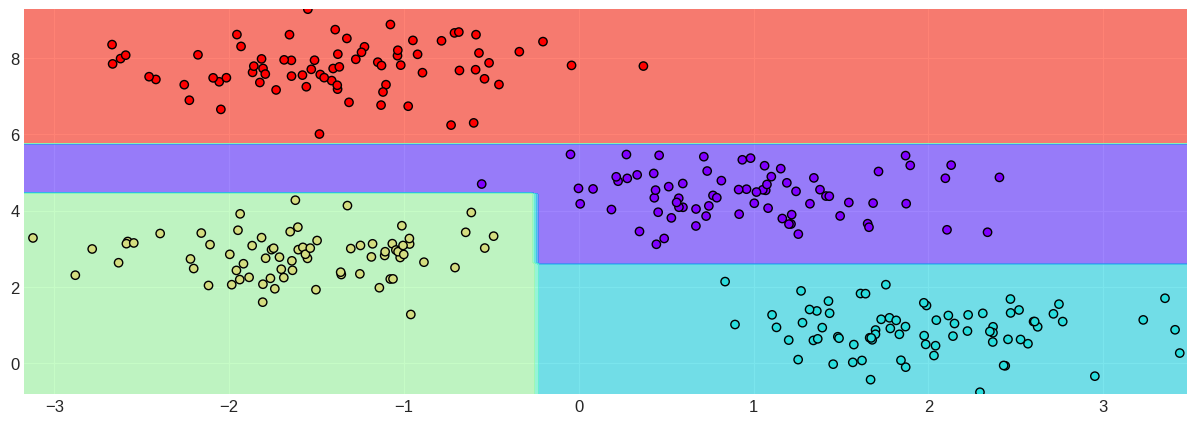

In [8]:
fn_plot_decision_boundary(clf, X, y)

## Controlling complexity of decision trees

In [9]:
data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    data.data, 
    data.target, 
    stratify=data.target, 
    random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

tree.fit(X_train, y_train)

print("Accuracy on train set: {:.3f}".format(tree.score(X_train, y_train)))

print("Accuracy on test set : {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on train set: 1.000
Accuracy on test set : 0.895


In [10]:
tree = DecisionTreeClassifier(max_depth=3, 
                              random_state=RANDOM_STATE)

tree.fit(X_train, y_train)

print("Accuracy on train set: {:.3f}".format(tree.score(X_train, y_train)))

print("Accuracy on test set : {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on train set: 0.984
Accuracy on test set : 0.902


In [11]:
export_graphviz(tree, out_file="../output/tree.dot", class_names=["malignant", "benign"],
                feature_names=data.feature_names, impurity=False, filled=True)

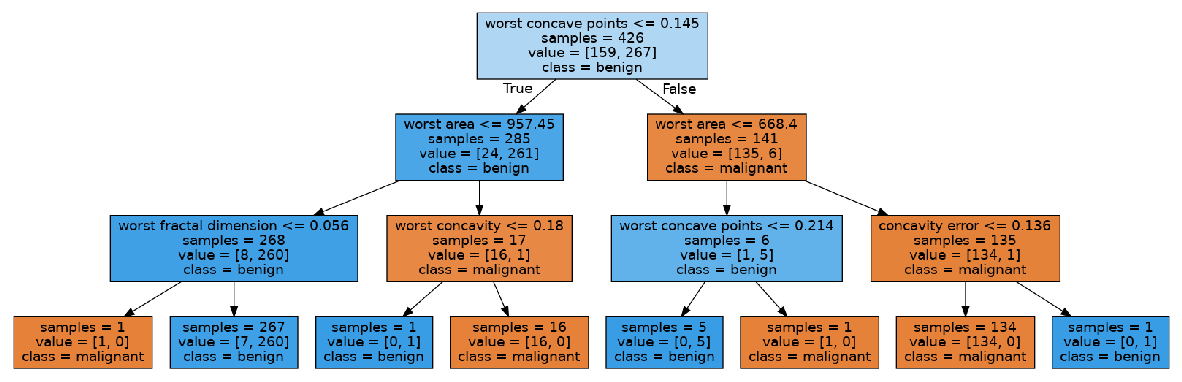

In [12]:
with open("../output/tree.dot") as f:
    dot_graph = f.read()
img = graphviz.Source(dot_graph)
! dot -Tpng ../output/tree.dot -o ../output/tree.png
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(mpimg.imread("../output/tree.png"));

In [13]:
# feature importance considering full depth

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

tree.fit(X_train, y_train)

print("Feature importances:")

print(tree.feature_importances_)


Feature importances:
[0.         0.02218621 0.         0.         0.00836219 0.
 0.         0.00877635 0.         0.         0.         0.00448918
 0.         0.         0.0080277  0.         0.         0.0080277
 0.00501731 0.00188391 0.         0.00999246 0.         0.17254873
 0.0099603  0.         0.00944435 0.72180374 0.         0.00947986]


(-1.0, 30.0)

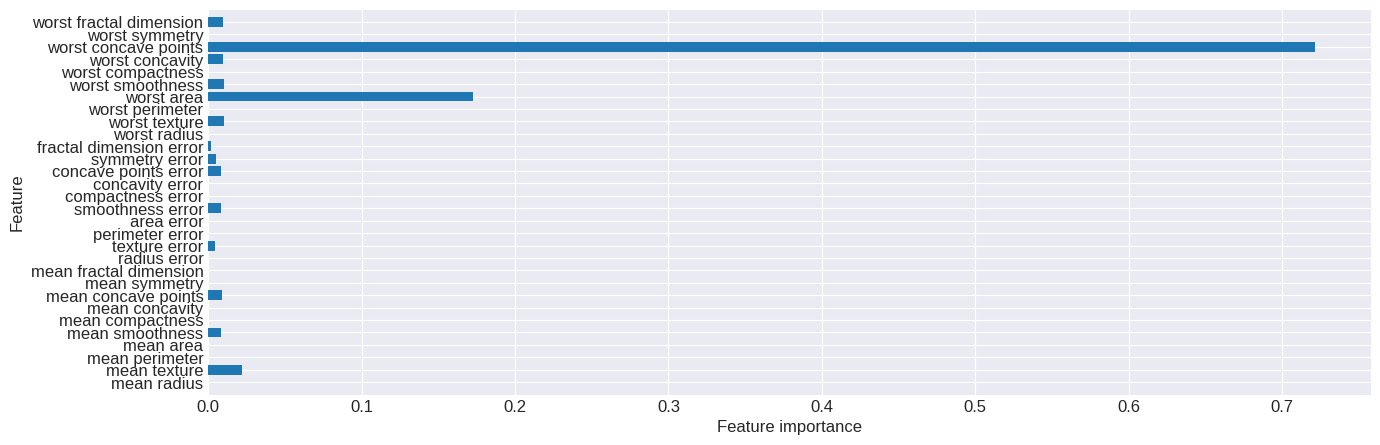

In [14]:
n_features = data.data.shape[1]

plt.barh(np.arange(n_features), 
         tree.feature_importances_, 
         align='center')

plt.yticks(np.arange(n_features), data.feature_names)

plt.xlabel("Feature importance")

plt.ylabel("Feature")

plt.ylim(-1, n_features)

## Decision Tree Regressor

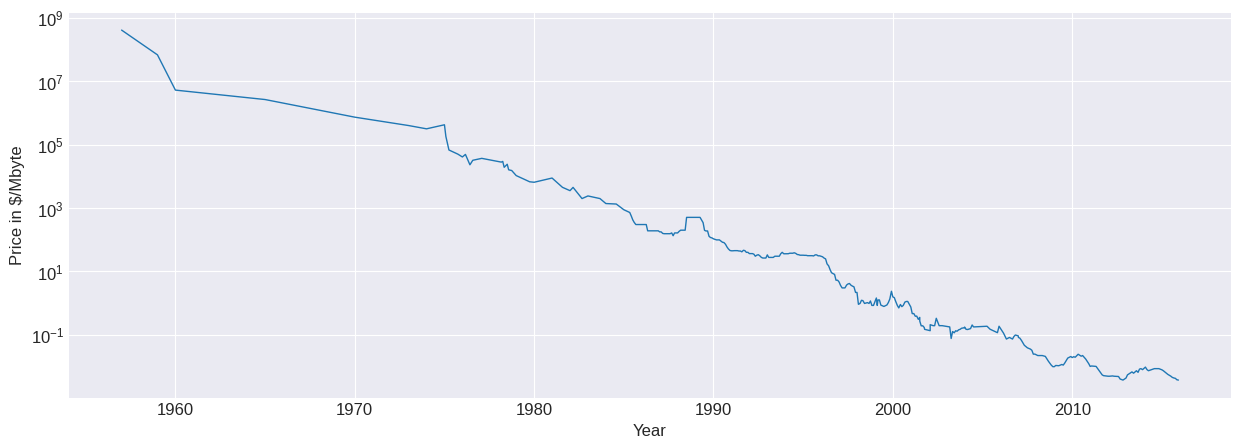

In [15]:
ram_prices = pd.read_csv(os.path.join(inpDir, moduleDir,"ram_price.csv"))

fig, ax = plt.subplots()

ax.semilogy(ram_prices.date, ram_prices.price)
ax.set_xlabel("Year")
ax.set_ylabel("Price in $/Mbyte")
plt.show()

In [16]:
# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]

data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = data_train.date.to_numpy()[:, np.newaxis]

# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)

linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date.to_numpy()[:, np.newaxis]

pred_tree = tree.predict(X_all)

pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)

price_lr = np.exp(pred_lr)

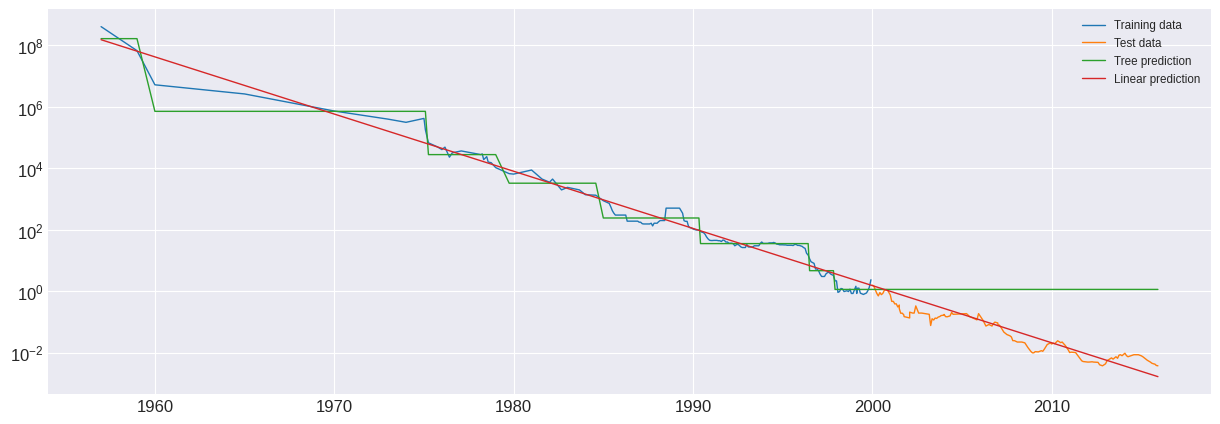

In [17]:
fig, ax = plt.subplots()

ax.semilogy(data_train.date, data_train.price, label="Training data")

ax.semilogy(data_test.date, data_test.price, label="Test data")

ax.semilogy(ram_prices.date, price_tree, label="Tree prediction")

ax.semilogy(ram_prices.date, price_lr, label="Linear prediction")

plt.legend();